**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import pylab
import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree

%load_ext pycodestyle_magic

In [78]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform', algorithm='brute',
                 metric='minkowski', p=2):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.metric = metric
        self.m_p = p

    def fit(self, X, y):
        self.data = X
        self.target = y
        self.n_classes = len(np.unique(y))
        return self

    def distance(self, t):
        return (np.sum((self.data - t) ** self.m_p, axis=1)) ** (1 / self.m_p)

    def euclidean_distance(self, t):
        return np.sqrt(np.sum((self.data - t) ** 2, axis=1))

    def find_class_brute(self, t):
        mas = self.distance(t)
        a = (mas.argsort())[:self.n_neighbors]
        imp = np.zeros(self.n_classes)
        ans = -1
        for i in range(self.n_neighbors):
            if mas[a[i]] <= 1e-9:
                ans = self.target[a[i]]
                break
            imp[self.target[a[i]]] += (1 / mas[a[i]])
        if ans == -1:
            ans = imp.argmax()
        return ans

    def find_class_kd_tree(self, X):
        tree = KDTree(self.data, leaf_size=self.n_neighbors)
        mas, ind = tree.query(X, k=self.n_neighbors)
        ans = np.zeros(len(X)) - 1
        for i in range(len(X)):
            imp = np.zeros(self.n_classes)
            for j in range(self.n_neighbors):
                if mas[i][j] <= 1e-9:
                    ans[i] = self.target[ind[i][j]]
                    break
                imp[int(self.target[ind[i][j]])] += (1 / mas[i][j])
            if ans[i] == -1:
                ans[i] = int(imp.argmax())
        return ans

    def predict(self, X):
        if self.algorithm == 'brute':
            ans = np.zeros(len(X))
            distance = cdist(X, self.data)
            for j in range(len(X)):
                mas = distance[j]
                a = (mas.argsort())[:self.n_neighbors]
                imp = np.zeros(self.n_classes)
                ans[j] = -1
                for i in range(self.n_neighbors):
                    if mas[a[i]] <= 1e-15:
                        ans[j] = self.target[a[i]]
                        break
                    imp[int(self.target[int(a[i])])] += (1 / mas[a[i]])
                if ans[j] == -1:
                    ans[j] = imp.argmax()
            self.ans = ans

        if self.algorithm == 'kd_tree':
            self.ans = self.find_class_kd_tree(X)
            ans = self.ans
        return ans

    def predict_proba(self, X):
        W = np.zeros((len(X), self.n_classes))

        if self.algorithm == 'brute':
            distance = cdist(X, self.data)
            for j in range(len(X)):
                a = (distance[j].argsort())[:self.n_neighbors]
                for i in range(self.n_neighbors):
                    W[j][int(self.target[int(a[i])])] += 1
                W[j] /= self.n_neighbors

        if self.algorithm == 'kd_tree':
            tree = KDTree(self.data, leaf_size=self.n_neighbors)
            mas, ind = tree.query(X, k=self.n_neighbors)
            for j in range(len(X)):
                for i in range(self.n_neighbors):
                    W[j][int(self.target[int(ind[j][i])])] += 1
                W[j] /= self.n_neighbors

        return W

    def score(self, X, y):
        a = self.ans
        sc = 0
        i = 0
        for p in a:
            if int(p) == int(y[i]):
                sc += 1
            i += 1
        sc = sc / int(len(X))
        return sc


**IRIS**

In [45]:
iris = datasets.load_iris()


In [46]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [47]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [48]:
%time clf.fit(X_train, y_train)

Wall time: 3.47 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [49]:
%time my_clf.fit(X_train, y_train)

Wall time: 606 µs


MyKNeighborsClassifier(algorithm='brute', metric='minkowski', n_neighbors=2,
            p=None, weights='uniform')

In [50]:
%time clf.predict(X_test)

Wall time: 7.41 ms


array([0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 2])

In [51]:
%time my_clf.predict(X_test)

Wall time: 2.48 ms


array([0., 1., 0., 1., 0., 2., 1., 2., 0., 2., 1., 2., 1., 0., 2.])

In [52]:
%time clf.predict_proba(X_test)

Wall time: 1.98 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [53]:
%time my_clf.predict_proba(X_test)

Wall time: 3.96 ms


array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [54]:
clf.score(X_test, y_test)

0.9333333333333333

In [55]:
my_clf.score(X_test, y_test)

1.0

Задание 3

The best score for n = 13


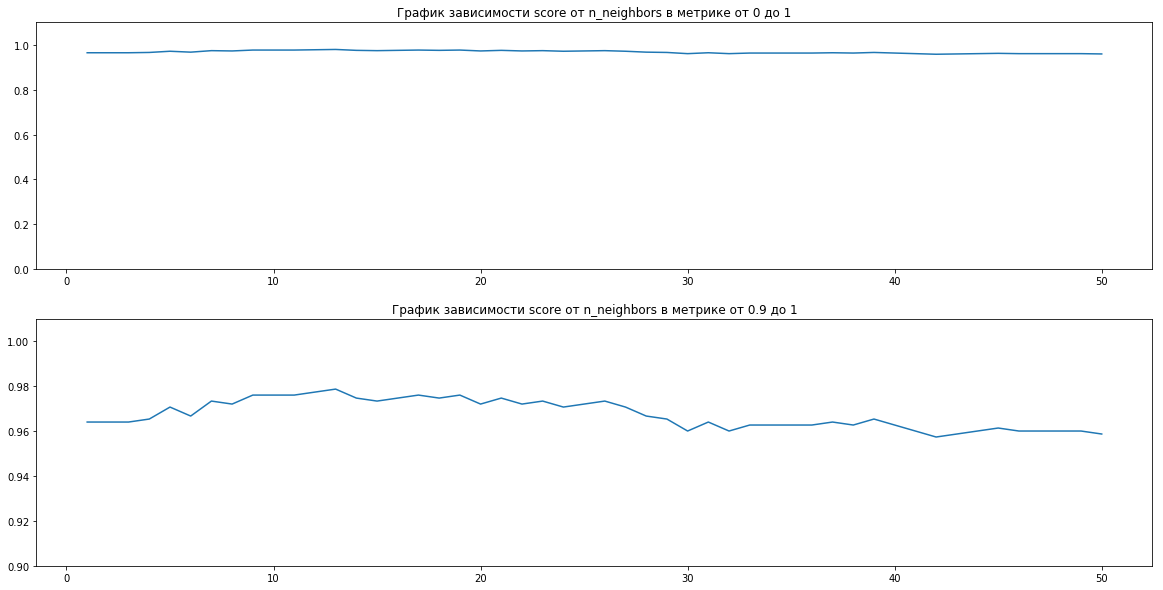

In [56]:
iris = datasets.load_iris()
x = np.arange(1, 51)
y = np.zeros(shape=50)

for j in range(50):
    X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, 
    stratify=iris.target)
    for i in range(1, 51):
        my_clf = MyKNeighborsClassifier(n_neighbors = i)
        my_clf.data = X_train
        my_clf.target = y_train
        my_clf.n_classes = len(np.unique(y_train))
        my_clf.predict(X_test)
        y[i-1] += my_clf.score(X_test, y_test)
        
y = y / 50        
t = x[y.argmax()]
print('The best score for n = ' + str(t))

fig = pylab.figure(figsize = (20, 10))
ax = fig.add_subplot(211) 
ax.plot(x, y)
pylab.ylim(0, 1.1)
ax.set_title('График зависимости score от n_neighbors в метрике от 0 до 1')

ax1 = fig.add_subplot(212)
ax1.plot(x, y)
pylab.ylim(0.9, 1.01)
ax1.set_title('График зависимости score от n_neighbors в метрике от 0.9 до 1')

pylab.show()



**MNIST**

In [57]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

clf = KNeighborsClassifier(n_neighbors=17)
my_clf = MyKNeighborsClassifier(n_neighbors=17)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [59]:
clf = KNeighborsClassifier(n_neighbors = 17)
my_clf = MyKNeighborsClassifier(n_neighbors = 17)

In [60]:
%time clf.fit(X_train, y_train)

Wall time: 48.3 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='uniform')

In [61]:
%time my_clf.fit(X_train, y_train)

Wall time: 56 ms


MyKNeighborsClassifier(algorithm='brute', metric='minkowski', n_neighbors=17,
            p=None, weights='uniform')

In [62]:
%time clf.predict(X_test)

Wall time: 2min 13s


array(['3', '8', '8', '7', '6', '1', '8', '2', '3', '6', '6', '3', '4',
       '6', '2', '7', '7', '0', '4', '2', '6', '4', '2', '7', '9', '3',
       '3', '9', '9', '7', '1', '6', '6', '3', '8', '8', '1', '5', '1',
       '7', '0', '9', '2', '1', '3', '6', '2', '5', '5', '6', '9', '9',
       '0', '7', '8', '0', '1', '3', '3', '8', '5', '6', '8', '2', '2',
       '4', '8', '9', '5', '8', '9', '8', '8', '2', '5', '9', '3', '4',
       '7', '3', '9', '9', '8', '9', '4', '1', '4', '0', '0', '1', '6',
       '0', '0', '3', '3', '8', '4', '9', '5', '9', '8', '2', '0', '5',
       '1', '8', '2', '8', '8', '4', '8', '9', '7', '6', '6', '1', '2',
       '4', '0', '2', '2', '8', '8', '7', '2', '4', '0', '7', '6', '0',
       '8', '0', '1', '3', '8', '2', '8', '9', '7', '5', '7', '4', '1',
       '9', '7', '6', '0', '0', '1', '1', '2', '1', '5', '9', '0', '0',
       '3', '1', '6', '6', '3', '8', '1', '6', '5', '0', '3', '7', '8',
       '4', '8', '2', '3', '7', '0', '2', '1', '0', '1', '9', '0

In [63]:
%time my_clf.predict(X_test)

Wall time: 1min 37s


array([3., 8., 8., 7., 6., 1., 8., 2., 3., 6., 6., 3., 4., 6., 2., 7., 7.,
       0., 4., 2., 6., 4., 2., 7., 9., 3., 3., 9., 9., 7., 1., 6., 6., 3.,
       8., 8., 1., 5., 1., 7., 0., 9., 2., 1., 3., 6., 2., 5., 5., 6., 9.,
       9., 0., 7., 8., 0., 1., 3., 3., 8., 5., 6., 8., 2., 2., 4., 8., 9.,
       5., 8., 9., 8., 8., 2., 5., 9., 8., 4., 7., 3., 9., 9., 8., 9., 4.,
       1., 4., 0., 0., 1., 6., 0., 0., 3., 3., 8., 4., 9., 5., 9., 8., 2.,
       0., 5., 1., 8., 2., 8., 8., 4., 8., 9., 7., 6., 6., 1., 2., 4., 0.,
       2., 2., 8., 8., 7., 2., 4., 0., 7., 6., 0., 8., 0., 1., 3., 8., 2.,
       8., 9., 7., 5., 7., 4., 1., 9., 7., 6., 0., 0., 1., 1., 2., 1., 5.,
       9., 0., 0., 3., 1., 6., 6., 3., 8., 1., 6., 5., 0., 3., 7., 8., 4.,
       8., 2., 3., 7., 0., 2., 1., 0., 1., 9., 0., 4., 1., 9., 4., 2., 6.,
       2., 4., 4., 6., 7., 1., 7., 4., 0., 6., 7., 2., 5., 4., 4., 4., 2.,
       4., 9., 1., 6., 3., 4., 4., 0., 7., 4., 0., 5., 5., 0., 9., 7., 9.,
       1., 3., 5., 8., 5.

In [64]:
%time clf.predict_proba(X_test)

Wall time: 2min 22s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [65]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 37s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [66]:
clf.score(X_test, y_test)

0.9728571428571429

In [67]:
my_clf.score(X_test, y_test)

0.9757142857142858

Задание 4

In [79]:
clf = KNeighborsClassifier(n_neighbors=13, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=13, algorithm='kd_tree')

In [80]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [81]:
%time clf.fit(X_train, y_train)

Wall time: 29.8 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')

In [82]:
%time my_clf.fit(X_train, y_train)

Wall time: 38.7 ms


MyKNeighborsClassifier(algorithm='kd_tree', metric='minkowski',
            n_neighbors=18, p=None, weights='uniform')

In [83]:
%time clf.predict(X_test)

Wall time: 1min 13s


array(['1', '5', '3', '4', '7', '9', '3', '9', '6', '4', '4', '6', '0',
       '0', '9', '4', '1', '2', '4', '7', '8', '9', '4', '1', '4', '5',
       '4', '0', '9', '6', '0', '3', '3', '5', '1', '3', '4', '0', '9',
       '4', '1', '5', '7', '8', '1', '2', '1', '0', '6', '2', '0', '4',
       '7', '2', '0', '7', '7', '6', '1', '3', '7', '4', '5', '0', '4',
       '4', '7', '7', '9', '8', '1', '3', '7', '4', '2', '3', '2', '5',
       '6', '2', '8', '9', '3', '6', '4', '1', '4', '4', '0', '2', '2',
       '4', '7', '8', '7', '3', '1', '3', '0', '7', '3', '6', '3', '1',
       '5', '1', '4', '8', '2', '4', '8', '3', '9', '3', '2', '7', '3',
       '2', '3', '9', '8', '7', '1', '1', '7', '8', '2', '0', '6', '5',
       '7', '8', '2', '9', '3', '7', '8', '7', '2', '0', '8', '5', '1',
       '9', '1', '5', '2', '4', '1', '0', '4', '7', '4', '9', '8', '4',
       '9', '8', '6', '0', '8', '8', '2', '2', '0', '2', '0', '4', '1',
       '4', '2', '0', '6', '2', '5', '0', '8', '5', '0', '6', '4

In [84]:
%time my_clf.predict(X_test)

Wall time: 1min 39s


array([1., 5., 3., 4., 7., 9., 3., 9., 6., 4., 4., 6., 0., 0., 9., 4., 1.,
       2., 4., 7., 8., 9., 7., 1., 4., 5., 4., 0., 9., 6., 0., 3., 3., 5.,
       1., 3., 4., 0., 9., 4., 1., 5., 7., 8., 1., 2., 1., 0., 6., 2., 0.,
       4., 7., 2., 0., 7., 7., 6., 1., 3., 7., 4., 5., 0., 4., 4., 7., 7.,
       9., 8., 1., 3., 7., 4., 2., 3., 2., 5., 6., 2., 8., 9., 3., 6., 4.,
       1., 4., 4., 0., 2., 2., 4., 7., 8., 7., 3., 1., 3., 0., 7., 3., 6.,
       3., 1., 5., 1., 4., 8., 2., 4., 8., 3., 9., 3., 2., 7., 3., 2., 3.,
       9., 8., 7., 1., 1., 7., 8., 2., 0., 6., 5., 7., 8., 2., 9., 3., 7.,
       8., 7., 2., 0., 8., 5., 1., 9., 1., 5., 2., 4., 1., 0., 4., 7., 4.,
       9., 8., 4., 9., 8., 6., 0., 8., 8., 2., 2., 0., 2., 0., 4., 1., 4.,
       2., 0., 6., 2., 5., 0., 8., 5., 0., 6., 4., 8., 9., 2., 1., 2., 3.,
       3., 3., 9., 2., 9., 1., 2., 6., 5., 6., 2., 0., 7., 1., 7., 1., 0.,
       0., 2., 4., 5., 9., 0., 0., 4., 8., 3., 7., 6., 0., 3., 5., 0., 5.,
       9., 1., 5., 2., 1.

In [85]:
%time clf.predict_proba(X_test)

Wall time: 1min 10s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [86]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 45s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [87]:
clf.score(X_test, y_test)

0.9714285714285714

In [88]:
my_clf.score(X_test, y_test)

0.9757142857142858

Задание 5

In [ ]:
# seaborn
# это библиотека Python, основанная на Matplotlib, 
# созданная для визуализации данных.
# Она обеспечивает интерфейс высокого уровня 
# для рисования привлекательной и информативной статистической графики.

# matplotlib
# библиотека на языке программирования Python 
# для визуализации данных двумерной графикой.
# Библиотека Matplotlib построена на принципах ООП, 
# но имеет процедурный интерфейс pylab.

# train_test_split
# утилита из библиотеки sklearn, которая разбивает массивы
# и матрицы на обучающие и тестовые выборки.

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
# Загружает расширение IPython в notebook по имени e из предобработчика 
# данных Pipeline, который функционирует как составной классификатор

# StandardScaler (from sklearn.preprocessing import StandardScaler)
# Метод,осуществляющий стандартизацию объектов путем удаления среднего 
# и масштабирования до единичной дисперсии.

# ClassifierMixin
# Mixin класс для всех классификаторов в sklearn. 
# В частности, он используется для вычисления 
# среднего значения точности на данных и метках 

# NeighborsBase
# Базовый класс Python, который используется для поиска 
# К ближайших соседей и посика соседей в заданном радиусе.
# Параметры: (n_neighbors, radius, algorithm, leaf_size, 
# metric, p, metric_params, n_jobs )

# KNeighborsMixin
# класс python, используемый для поиска K ближайших соседей. 
# Основные методы: kneighbors, kneighbors_graph, _kneighbors_reduce_func.

# SupervisedIntegerMixin
# класс Python, который проверяет корректность параметров, 
# выполняет операцию проверки типа, 
# а затем вызывает _fit метода NeighborsBass
